## Candidato: Wesley Pereira da Silva
### Data: 26/09/2021

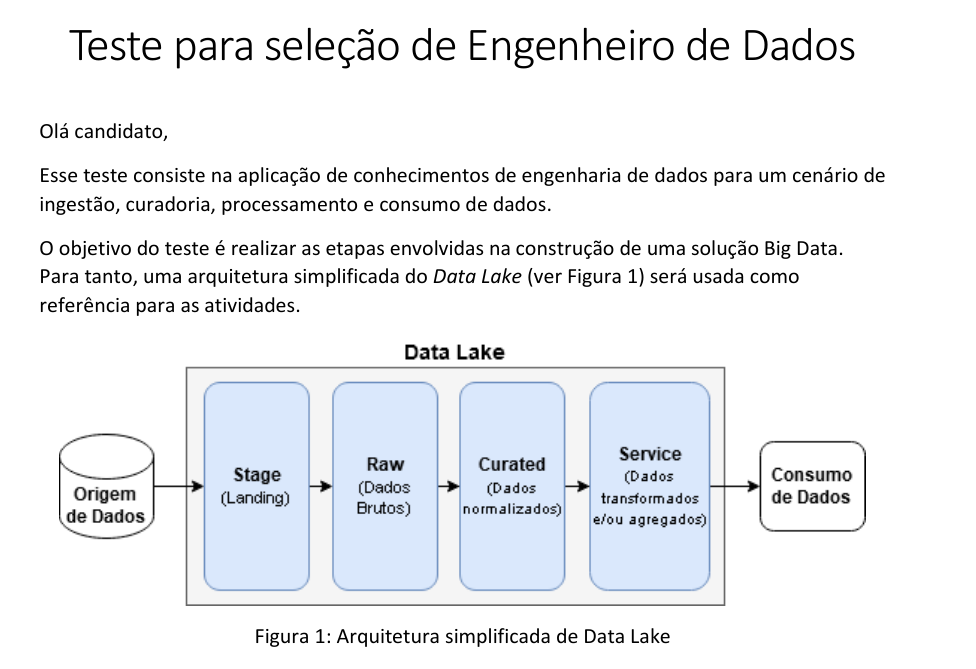

In [1]:
from IPython.display import Image
Image(filename='./enunciados/1.png')


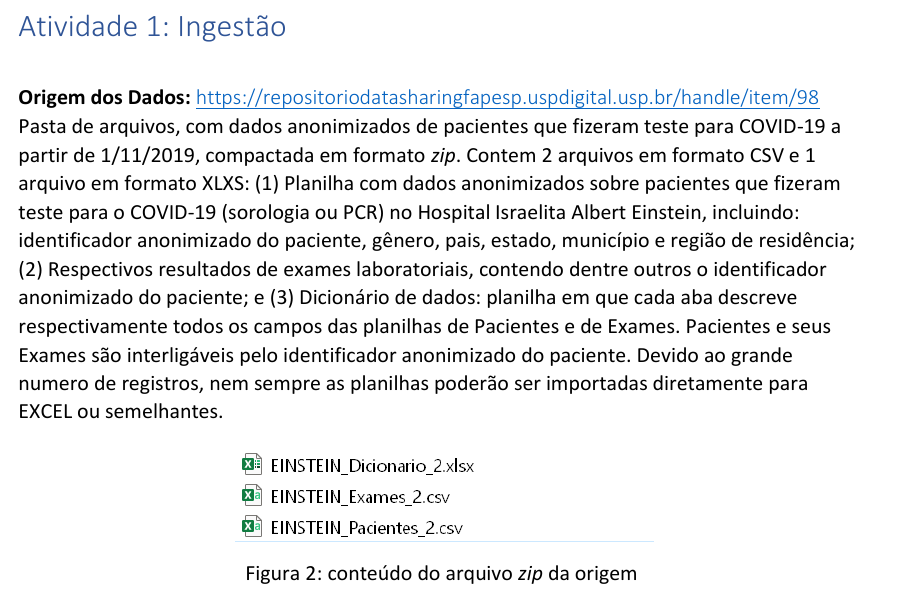

In [2]:
Image(filename='./enunciados/1b.png')

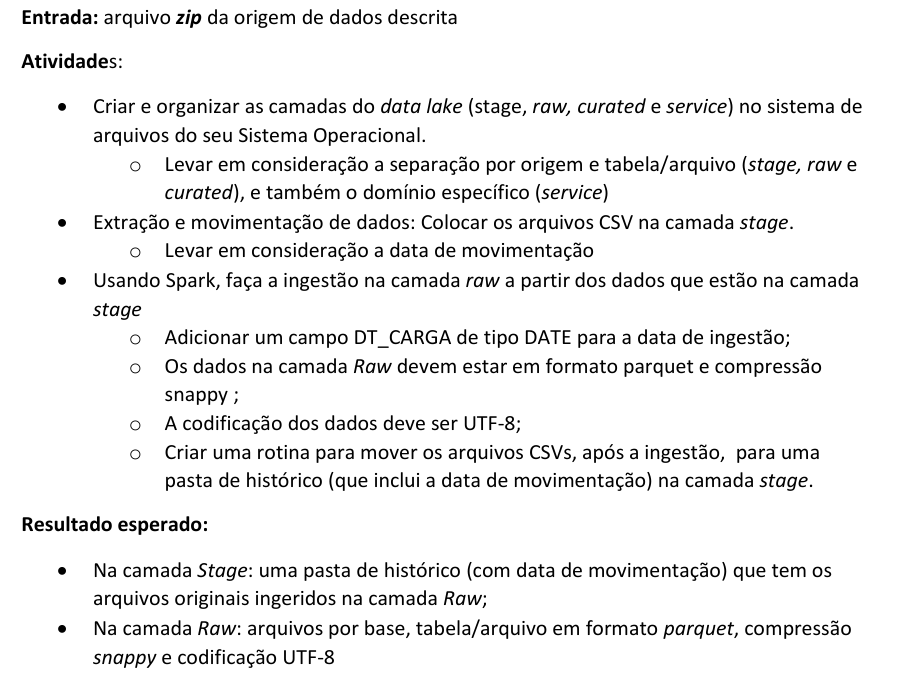

In [2]:
Image(filename='./enunciados/1c.png')

### A classe Covid_Test realiza as operações pedidas na atividade 1. 

In [12]:
import findspark
findspark.init()
import pyspark
from pathlib import Path
import zipfile
import os
from datetime import date
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from delta import *
from pyspark.sql.functions import current_date
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt

In [2]:
"""
Classe que trata dos processos pedidos na atividade 1: Ingestão

a) Método init: No método de inicialização, é criada a estrutura de diretórios e registra a data no nome do arquivo.
b) Método load_url_files: O método  carrega o path dos arquivos .csv
c) Método load_spark: carrega o objeto spark para carga do csv e inserção no datalake.
d) Método load_stage_to_raw: insere os dados no datalake.
"""
class Covid_Test_Atividade_1:
    def __init__(self):
        self.paths = ['stage', 'raw', 'curated', 'service']
        for p in self.paths:
            Path(p).mkdir(parents=True, exist_ok=True)     
            

        path = self.paths[0]
        #os.system('rm ./stage/*.csv')
        today = str(date.today())            
        with zipfile.ZipFile("./EINSTEINAgosto.zip", 'r') as zip_ref:
            os.system('mkdir tmpzip')
            zip_ref.extractall("./"+"tmpzip")
        
        
        files = os.listdir("./tmpzip/")
        for index, file in tqdm(enumerate(files)):
            
            if "ipynb" not in file:
                os.rename(os.path.join("./tmpzip/", file), os.path.join(path, ''.join([today+"_"+ file])))
            
        self.load_url_files()
        self.load_spark()
        self.load_stage_to_raw()
        os.system("rm -R ./tmpzip")
        
        
    def load_url_files(self, ):
        self.dfs  = {}
        for path in tqdm(Path('./').rglob('*.csv')):        
            self.dfs[path.name.replace(".csv", "")] = str(path) #pd.read_csv(path, sep='|')
            
    def load_spark(self, ):
        self.builder = pyspark.sql.SparkSession.builder.appName("Einstein_Covid_Test").config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension").config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
        self.spark =  configure_spark_with_delta_pip(self.builder).getOrCreate()
        
        
    def load_stage_to_raw(self, ):
        self.df_pacientes_raw = self.spark.read.csv(self.dfs[list(self.dfs.keys())[1]],header=True,  sep='|', inferSchema=True)
        self.df_pacientes_raw  = self.df_pacientes_raw.withColumn("DT_CARGA", current_date())
        self.df_pacientes_raw.write.mode("overwrite")\
        .format("delta")\
        .option("overwriteSchema", "true")\
        .option("compression", "snappy")\
        .option("encoding", "UTF-8")\
        .save("./"+self.paths[1]+"/pacientes.parquet")                
        self.df_exames_raw = self.spark.read.csv(self.dfs[list(self.dfs.keys())[0]],header=True,  sep='|', inferSchema=True)
        self.df_exames_raw  = self.df_exames_raw.withColumn("DT_CARGA", current_date())
        self.df_exames_raw.write.mode("overwrite")\
        .format("delta")\
        .option("overwriteSchema", "true")\
        .option("compression", "snappy")\
        .option("encoding", "UTF-8")\
        .save("./"+self.paths[1]+"/exames.parquet")


In [4]:
atividade1 = Covid_Test_Atividade_1()


3it [00:00, 6643.56it/s]
4it [00:00, 495.72it/s]
21/09/30 00:36:16 WARN Utils: Your hostname, devserver resolves to a loopback address: 127.0.1.1; using 192.168.196.129 instead (on interface ens33)
21/09/30 00:36:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/wesley/.ivy2/cache
The jars for the packages stored in: /home/wesley/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bc957149-8e64-418f-8b63-b51318d9495e;1.0
	confs: [default]
	found io.delta#delta-core_2.12;1.0.0 in central
	found org.antlr#antlr4;4.7 in central
	found org.antlr#antlr4-runtime;4.7 in central
	found org.antlr#antlr-runtime;3.5.2 in central
	found org.antlr#ST4;4.0.8 in central
	found org.abego.treelayout#org.abego.treelayout.core;1.0.3 in central
	found org.glassfish#javax.json;1.0.4 in central
	found com.ibm.icu#icu4j;58.2 in central
:: resolution report :: resolve 279ms :: artifacts dl 32ms
	:: modules in use:
	com.ibm.icu#icu4j;58.2 from central in [default]
	io.delta#delta-core_2.12;1.0.0 from central in [default]
	org.abego.treelayout#org.abego.treelayout.core;1.0.3 from central in [default]
	org.antlr#ST4;4.0.8 from central in [default]
	org.antlr#antlr-run

In [5]:
atividade1.spark

In [6]:
atividade1.spark.catalog.listDatabases()

[Database(name='default', description='default database', locationUri='file:/home/wesley/workspace/einstein/spark-warehouse')]

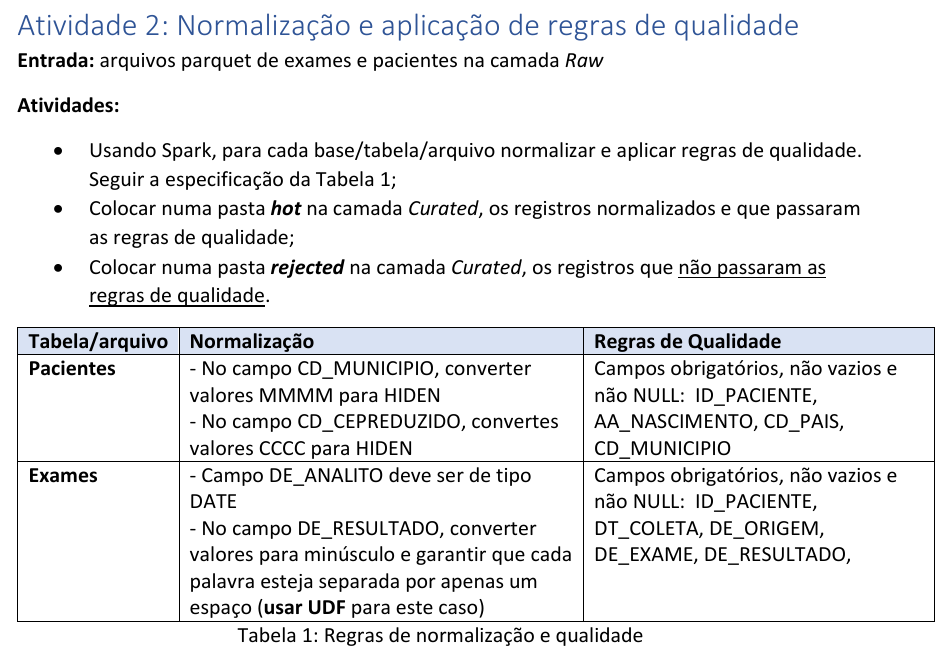

In [10]:
Image(filename='./enunciados/2.png')

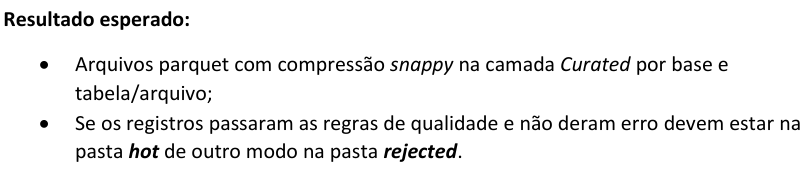

In [11]:
Image(filename='./enunciados/2b.png')

In [12]:
import pyspark.sql.functions as F
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [100]:
"""

"""
def singleSpace(col: Column):
    Column = {trim(regexp_replace(col, " +", " "))}

class Covid_Test_Atividade_2:
    def __init__(self, task1):
        self.task1 = task1
        self.paths = ['./curated/hot', './curated/reject']
        for p in self.paths:
            Path(p).mkdir(parents=True, exist_ok=True)              
            
        self.clean_dados_put_hot_reject()
        #self.df_pacientes_new.printSchema()
        #self.df_pacientes_new.show(5)
        
        
    def clean_dados_put_hot_reject(self, ):
        aux = self.task1.df_pacientes_raw
        # NORMALIZAÇÃO - CONVERSÃO DO VALOR CD_MUNICIPIO TO HIDEN
        aux = aux.withColumn("CD_MUNICIPIO", when(aux.CD_MUNICIPIO == "MMMM","HIDEN") \
                                                     .otherwise(aux.CD_MUNICIPIO))

        # NORMALIZAÇÃO - CONVERSÃO DO VALOR CD_CEPREDUZIDO TO HIDEN
        aux = aux.withColumn("CD_CEPREDUZIDO", when(aux.CD_CEPREDUZIDO == "CCCC","HIDEN") \
                                                     .otherwise(aux.CD_CEPREDUZIDO))
        
        # REGRAS DE QUALIDADE - FILTRAGEM DADOS NÃO NULOS
        #aux = aux.na.drop(how='any', subset=['ID_PACIENTE','AA_NASCIMENTO','CD_PAIS','CD_MUNICIPIO'])
        aux = aux.filter(aux.ID_PACIENTE.isNotNull() \
                         & aux.AA_NASCIMENTO.isNotNull()\
                         & aux.CD_PAIS.isNotNull() \
                         & aux.CD_MUNICIPIO.isNotNull())
                        
        
        
        # ARMAZENAMENTO FRAME PACIENTE PARA POSTERIOR FILTRAGEM E INSERÇÃO NA PASTA CURATED
        self.df_paciente_notnull = aux     
        
        
        # INSERÇÃO VALORES NÃO NULOS NA PASTA HOT
        self.df_paciente_notnull.write.mode("overwrite")\
            .format("delta")\
            .option("overwriteSchema", "true")\
            .option("compression", "snappy")\
            .option("encoding", "UTF-8")\
            .save("./"+self.task1.paths[2]+"/hot/pacientes.parquet")
  
        
        ########################################################
        # NORMALIZAÇÃO - CONVERSÃO DA DE_ANALITO PARA TIPO DATA
        aux = self.task1.df_exames_raw
        #aux = aux.withColumn("DT_COLETA",aux['DT_COLETA'].cast(DateType()))        
        
        # NORMALIZAÇÃO - REMOÇÃO DE ESPAÇOS EM BRANCO NA STRING
        aux = aux.withColumn("DE_RESULTADO", trim(aux['DE_RESULTADO']))
        
        # REGRAS DE QUALIDADE - FILTRAGEM DADOS NÃO NULO
        
        aux = aux.filter(aux.ID_PACIENTE.isNotNull() \
                         & aux.DT_COLETA.isNotNull()\
                         & aux.DE_ORIGEM.isNotNull() \
                         & aux.DE_RESULTADO.isNotNull() \
                         & aux.DE_EXAME.isNotNull())
        
        self.df_exames_notnull = aux
        
        
        # INSERÇÃO VALORES NÃO NULOS NA PASTA HOT
        self.df_exames_notnull.write.mode("overwrite")\
            .format("delta")\
            .option("overwriteSchema", "true")\
            .option("compression", "snappy")\
            .option("encoding", "UTF-8")\
            .save("./"+self.task1.paths[2]+"/hot/exames.parquet")
        
        aux = self.task1.df_exames_raw

        aux2 = aux.filter(aux.ID_PACIENTE.isNull() & 
                   aux.DT_COLETA.isNull() &
                   aux.DE_ORIGEM.isNull() &           
                   aux.DE_EXAME.isNull() &
                   aux.DE_RESULTADO.isNull() 
                  )


        # INSERÇÃO VALORES NULOS NA PASTA REJECT
        if aux2.count() > 0:
            aux2.write.mode("overwrite")\
            .format("delta")\
            .option("overwriteSchema", "true")\
            .option("compression", "snappy")\
            .option("encoding", "UTF-8")\
            .save("./"+self.task1.paths[2]+"/rejected/exames.parquet")

        
        aux = self.task1.df_pacientes_raw
        aux2 = aux.filter(aux.ID_PACIENTE.isNull() & 
                   aux.AA_NASCIMENTO.isNull() &           
                   aux.CD_MUNICIPIO.isNull() &
                   aux.CD_PAIS.isNull() 
                  )
        # INSERÇÃO VALORES NULOS NA PASTA REJECT
        if aux2.count() > 0:
            aux2.write.mode("overwrite")\
            .format("delta")\
            .option("overwriteSchema", "true")\
            .option("compression", "snappy")\
            .option("encoding", "UTF-8")\
            .save("./"+self.task1.paths[2]+"/rejected/pacientes.parquet")
            
        
        # count_missings(self.df_paciente_notnull)
        # count_missings(self.df_exames_notnull)
        
        
atividade2 = Covid_Test_Atividade_2(atividade1)


In [101]:
atividade2.df_exames_notnull.show(5)

+--------------------+----------+---------+--------------------+--------------------+------------+----------+-------------------+----------+
|         ID_PACIENTE| DT_COLETA|DE_ORIGEM|            DE_EXAME|          DE_ANALITO|DE_RESULTADO|CD_UNIDADE|DE_VALOR_REFERENCIA|  DT_CARGA|
+--------------------+----------+---------+--------------------+--------------------+------------+----------+-------------------+----------+
|00006490d57666d73...|04/06/2020|     HOSP| Dosagem de D-Dímero|            D-Dímero|         863| ng/mL FEU|              <=500|2021-09-30|
|00006490d57666d73...|04/06/2020|     HOSP|Hemograma com Pla...|                 RDW|        13.0|         %|        11.5 a 16.5|2021-09-30|
|00006490d57666d73...|04/06/2020|     HOSP|    Dosagem de Sódio|               Sódio|         134|     mEq/L|          135 a 145|2021-09-30|
|00006490d57666d73...|04/06/2020|     HOSP|Hemograma Contage...|         Eosinófilos|         1.3|         %|               null|2021-09-30|
|00006490d576

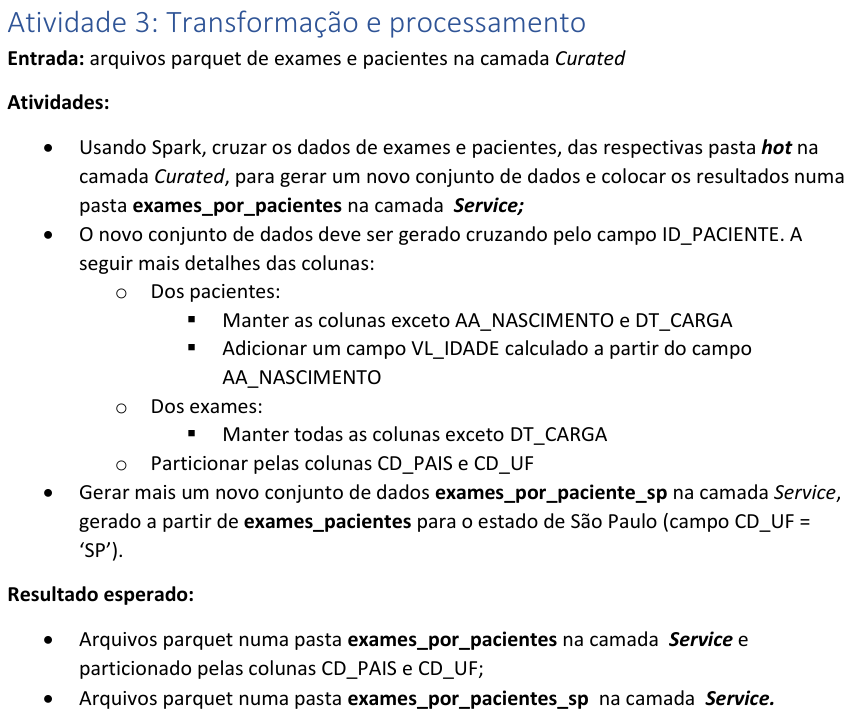

In [14]:
Image(filename='./enunciados/3.png')

In [102]:
class Covid_Test_Atividade_3:
    def __init__(self,):        
        self.paths = ['./service/exames_por_paciente', './service/exames_por_paciente_sp']
    
        for p in self.paths:
            Path(p).mkdir(parents=True, exist_ok=True)  
        self.load_data_from_curated()
    
    
    def load_data_from_curated(self, ):
        self.exames_hot = atividade1.spark.read.parquet("./curated/hot/exames.parquet")
        
        
        
        columns_to_drop = ['DT_CARGA','ID_PACIENTE']
        
        self.exames_hot = self.exames_hot.withColumn('ID_PAC',self.exames_hot['ID_PACIENTE'])
        self.exames_hot = self.exames_hot.drop(*columns_to_drop)
        
        
        
        self.pacientes_hot = atividade1.spark.read.parquet("./curated/hot/pacientes.parquet")
        
        #self.pacientes_hot = self.pacientes_hot.withColumn('ID_PAC',self.pacientes_hot['ID_PACIENTE'])
        
        self.pacientes_hot = self.pacientes_hot.withColumn('VL_IDADE',round(months_between(current_date(),col("AA_NASCIMENTO"))/lit(12),0))
        
        columns_to_drop = ['DT_CARGA', 'AA_NASCIMENTO']
        self.pacientes_hot = self.pacientes_hot.drop(*columns_to_drop)
        
        
        
        

        #self.exames_por_paciente = self.exames_hot.join(self.pacientes_hot, self.pacientes_hot.ID_PAC==self.exames_hot.ID_PACIENTE) 
        #                                       empDF.join(deptDF,empDF.emp_dept_id ==  deptDF.dept_id,"inner") \      .show(truncate=False)
        
        
        
        self.exames_por_paciente = self.pacientes_hot.join(self.exames_hot, self.pacientes_hot.ID_PACIENTE == self.exames_hot.ID_PAC)
        
        
        
        
        
        columns_to_drop = ['ID_PAC']
        self.exames_por_paciente = self.exames_por_paciente.drop(*columns_to_drop)
        
        self.exames_por_paciente.select('ID_PACIENTE', "DE_ANALITO","DE_RESULTADO").show(400)
        
        
        #print(self.exames_por_paciente.count(), len(self.exames_por_paciente.columns))
        
        #self.exames_por_paciente = exames_por_paciente
        
        self.exames_por_paciente.write.mode("overwrite").partitionBy("CD_PAIS", "CD_UF").format("delta").option("overwriteSchema", "true").option("compression", "snappy").option("encoding", "UTF-8").save(self.paths[0]+"/exame_por_paciente.parquet")     
        self.exames_por_paciente_sp = self.exames_por_paciente.filter(self.exames_por_paciente.CD_UF == 'SP')
        
        #print(self.exames_por_paciente_sp.count(), len(self.exames_por_paciente_sp.columns))
        
        
        self.exames_por_paciente_sp.write.mode("overwrite").partitionBy("CD_PAIS", "CD_UF").format("delta").option("overwriteSchema", "true").option("compression", "snappy").option("encoding", "UTF-8").save(self.paths[1]+"/exame_por_paciente_sp.parquet")
        
        

atividade3 = Covid_Test_Atividade_3()

+--------------------+--------------------+------------------+
|         ID_PACIENTE|          DE_ANALITO|      DE_RESULTADO|
+--------------------+--------------------+------------------+
|00006490d57666d73...|            D-Dímero|               863|
|00006490d57666d73...|                 RDW|              13.0|
|00006490d57666d73...|               Sódio|               134|
|00006490d57666d73...|         Eosinófilos|               1.3|
|00006490d57666d73...|               Uréia|                24|
|00006490d57666d73...|           Basófilos|               0.7|
|00006490d57666d73...|Volume Médio Plaq...|              10.1|
|00006490d57666d73...|         Hematócrito|              40.9|
|00006490d57666d73...|            Hemácias|              4.91|
|00006490d57666d73...|         Hemoglobina|              14.0|
|00006490d57666d73...|          Linfócitos|              33.2|
|00006490d57666d73...|           Plaquetas|               626|
|00006490d57666d73...|                CHCM|            

In [103]:
# atividade3.exame_por_paciente.show(10)

print((atividade3.exames_por_paciente.count(), len(atividade3.exames_por_paciente.columns)))

(3415155, 14)


In [104]:
print((atividade1.df_pacientes_raw.count(), len(atividade1.df_pacientes_raw.columns)))

(79863, 8)


In [105]:
atividade3.exames_por_paciente.select('ID_PACIENTE', "DE_ANALITO","DE_RESULTADO").show(40)

+--------------------+--------------------+------------+
|         ID_PACIENTE|          DE_ANALITO|DE_RESULTADO|
+--------------------+--------------------+------------+
|00006490d57666d73...|            D-Dímero|         863|
|00006490d57666d73...|                 RDW|        13.0|
|00006490d57666d73...|               Sódio|         134|
|00006490d57666d73...|         Eosinófilos|         1.3|
|00006490d57666d73...|               Uréia|          24|
|00006490d57666d73...|           Basófilos|         0.7|
|00006490d57666d73...|Volume Médio Plaq...|        10.1|
|00006490d57666d73...|         Hematócrito|        40.9|
|00006490d57666d73...|            Hemácias|        4.91|
|00006490d57666d73...|         Hemoglobina|        14.0|
|00006490d57666d73...|          Linfócitos|        33.2|
|00006490d57666d73...|           Plaquetas|         626|
|00006490d57666d73...|                CHCM|        34.2|
|00006490d57666d73...|      Eosinófilos  #|         157|
|00006490d57666d73...|         

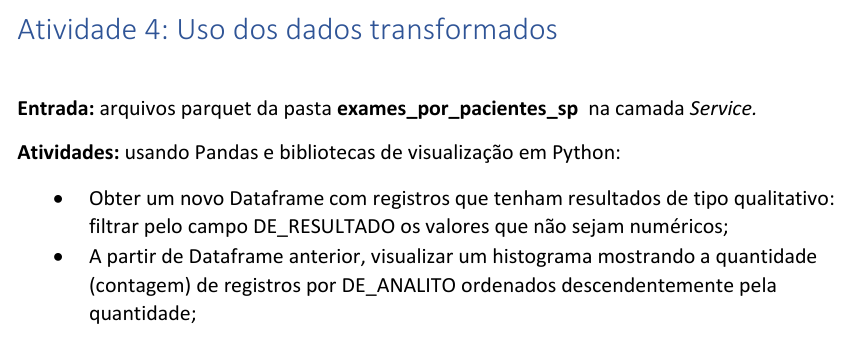

In [33]:
Image(filename='./enunciados/4.png')

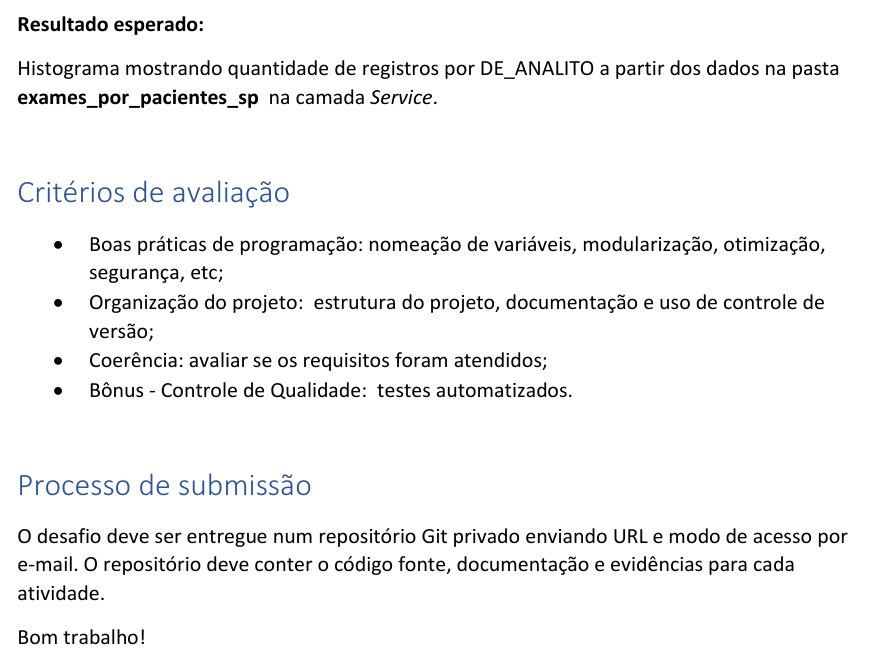

In [34]:
Image(filename='./enunciados/4b.png')

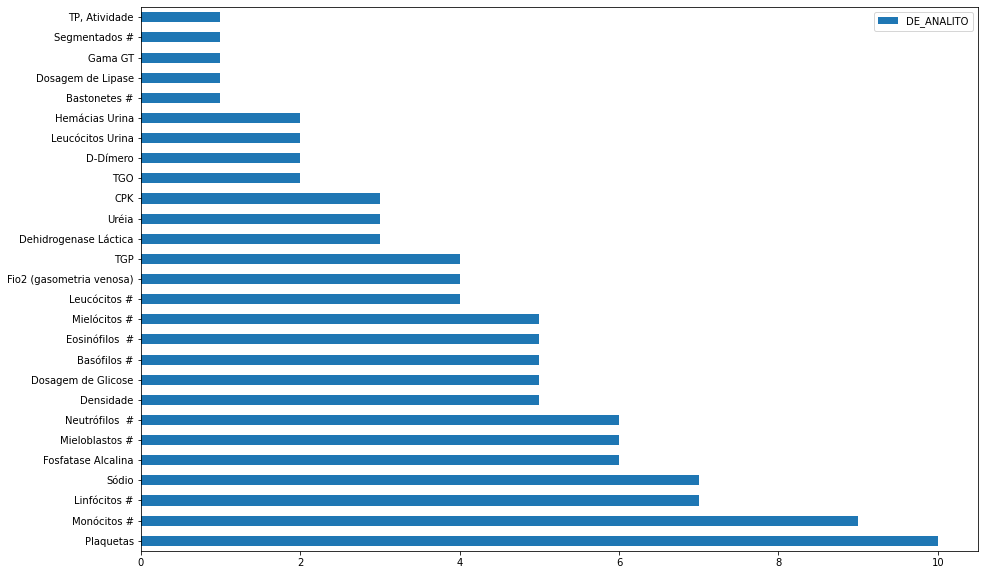

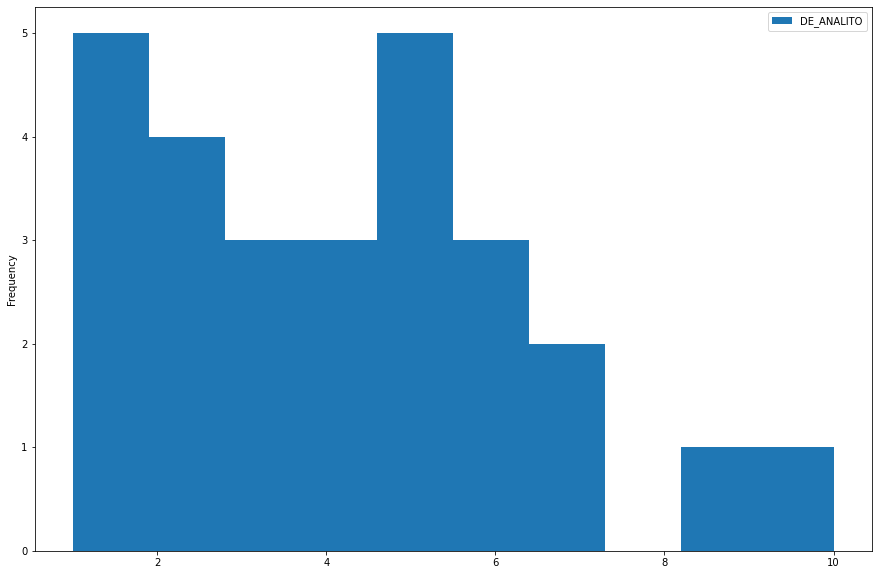

In [11]:


class Covid_Test_Atividade_4:
    def __init__(self,):
        self.exames_por_paciente_sp = atividade1.spark.\
                                                        read.parquet("./service/exames_por_paciente_sp/exame_por_paciente_sp.parquet")
        
        self.exames_por_paciente = atividade1.spark.\
                                                        read.parquet("./service/exames_por_paciente/exame_por_paciente.parquet")
        self.plot_dados()

    def plot_dados(self,) :
        
        aux4 = self.exames_por_paciente_sp.sample(False, 0.0001, seed=0)
        
        #print((aux4.count(), len(aux4.columns)))

        dfaux4 = aux4.toPandas()
        dfaux4 = dfaux4[['DE_RESULTADO','DE_ANALITO']]
        #dfaux4['DE_RESULTADO'] = dfaux4['DE_RESULTADO'].astype(str)
        dfaux4 = dfaux4[dfaux4['DE_RESULTADO'].str.isnumeric()]


        pd.DataFrame(dfaux4['DE_ANALITO'].value_counts()).plot(kind='barh', figsize=(15,10))

        plt.show()

        pd.DataFrame(dfaux4['DE_ANALITO'].value_counts()).plot(kind='hist', figsize=(15,10))
        
        
atividade4 = Covid_Test_Atividade_4()





